<div align="center">
	<h1>CS 328: Introduction to Data Science</h1>
	<h2>Assignment 1</h2>
	Shardul Junagade <br>
	23110297
</div>

### Importing Libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [20]:
class Cluster:
    def __init__(self, points):
        """Initialize a cluster with a list of points."""
        self.points = np.array(points)
        self.size = len(points)
        self.mean = self.compute_mean()
    
    def compute_mean(self):
        """Compute the mean of the cluster."""
        self.mean = np.mean(self.points, axis=0) if self.size > 0 else np.zeros(self.points.shape[1])
        return self.mean

## Question 1

Q1. Suppose you define a clustering objective in the following manner – given a partitioning $\mathbb{C} = \{C_1, \ldots, C_k\}$, define

$$
\text{cost}(\mathbb{C}) = \sum_i \frac{1}{|C_i|} \sum_{x, y \in C_i} \|x - y\|_2^2
$$

<div style="margin-left: 30px;">i.e., the cost of a cluster is the sum of all pairwise squared distances. Give an algorithm for this.</div>

### **Solution:**

To solve this problem, we need to design an algorithm that minimizes the given cost function for clustering. The cost function is defined as:

$$
\text{cost}(\mathbb{C}) = \sum_i \frac{1}{|C_i|} \sum_{x, y \in C_i} \|x - y\|_2^2
$$

This cost function penalizes clusters with large pairwise squared distances between points within the same cluster. Our goal is to minimize this cost by appropriately partitioning the data into $k$ clusters.

### Approach:

We can rewrite the cost function in terms of the mean of the clusters. Let $\mu_i$ be the mean of cluster $C_i$. The pairwise squared distance can be expressed as follows:

Expanding the paired distance:
$$
\|x - y\|_2^2 = \|x - \mu_i + \mu_i - y\|_2^2 = \|x - \mu_i\|_2^2 + \|\mu_i - y\|_2^2 + 2(x - \mu_i) \cdot (\mu_i - y)
$$

Expanding the sum over $x$ and $y$ in cluster $C_i$, we get:
$$
\sum_{x, y \in C_i} \|x - y\|_2^2 = \sum_{x \in C_i} \|x - \mu_i\|_2^2 + \sum_{y \in C_i} \|\mu_i - y\|_2^2 + 2 \sum_{x, y \in C_i} (x - \mu_i) \cdot (\mu_i - y)
$$

Since the dot product is symmetric, we have:
$$
\begin{align*}
\sum_{x, y \in C_i} (x - \mu_i) \cdot (\mu_i - y) &= \sum_{x, y \in C_i} (x \cdot \mu_i - x \cdot y - \mu_i \cdot \mu_i + \mu_i \cdot y) \\
&= |C_i|^2 \cdot \mu_i^2 - |C_i|^2 \cdot \mu_i^2 - |C_i|^2 \cdot \mu_i^2 + |C_i|^2 \cdot \mu_i^2 \\
&= 0
\end{align*}
$$

Since both sums are equal, we can write:
$$
\sum_{x, y \in C_i} \|x - y\|_2^2 = 2 \sum_{x \in C_i} \|x - \mu_i\|_2^2
$$

Substituting this back into the cost function, we get:
$$
\text{cost}(\mathbb{C}) = \sum_i \frac{1}{|C_i|} \cdot 2 \sum_{x \in C_i} \|x - \mu_i\|_2^2 = 2 \sum_i \frac{1}{|C_i|} \sum_{x \in C_i} \|x - \mu_i\|_2^2
$$

Thus, minimizing the original cost is equivalent to minimizing a weighted sum of the squared distances from each point to its cluster mean. This is similar to the k-means algorithm, where we iteratively assign points to the nearest cluster center and update the cluster centers to the mean of the points in the cluster.


### Computing the Cost Function:

The cost function can be computed as follows:
1. Initialize the cost to zero.
2. For each cluster $C_i$:
	- Compute the mean $\mu_i$ of the cluster.
	- For each point $x$ in the cluster:
		- Compute the squared distance $\|x - \mu_i\|_2^2$.
		- Divide this squared distance by the size of the cluster $|C_i|$.
		- Multiply this value by 2 and add it to the cost.
3. Return the total cost.

### Lloyd's Algorithm (k-Means Clustering):

**Input:** Data points $x_1, x_2, \ldots, x_n$, number of clusters $k$.

1. **Initialization**: Randomly initialize $k$ cluster centers $\mu_1, \mu_2, \ldots, \mu_k$.

2. **Assignment Step**: For each data point $x$, assign it to the cluster $C_i$ whose center $\mu_i$ minimizes the squared Euclidean distance:
     $$
     \|x - \mu_i\|_2^2
     $$

3. **Update Step**: For each cluster $C_i$, update the cluster center $\mu_i$ to be the mean of all points in $C_i$:
     $$
     \mu_i = \frac{1}{|C_i|} \sum_{x \in C_i} x
     $$

4. **Cost Calculation**:
   - After each iteration, compute the cost function:
     $$
     \text{cost}(\mathbb{C}) = \sum_{i=1}^{k} \sum_{x_j \in C_i} \left\| x_j - \mu_i \right\|^2
     $$
   - If the cost does not decrease significantly (below a threshold), stop the algorithm. Otherwise, repeat steps 2–4.

**Output:** The final clustering $\mathbb{C} = \{C_1, \ldots, C_k\}$.

<!-- ### Complexity Analysis:
- **Time Complexity**:
  - The assignment step requires computing the squared Euclidean distance between each point and each cluster center, which takes $O(n \cdot k \cdot d)$ time, where $n$ is the number of data points, $k$ is the number of clusters, and $d$ is the dimensionality of the data.
  - The update step requires computing the mean of each cluster, which takes $O(n \cdot d)$ time.
  - The algorithm typically converges in a few iterations, with each iteration taking $O(n \cdot k \cdot d)$ time.
  - Overall, the time complexity is $O(t \cdot n \cdot k \cdot d)$, where $t$ is the number of iterations until convergence.

- **Space Complexity**:
    - The algorithm requires $O(n \cdot d)$ space to store the data points and cluster centers.
    - Additional space is needed for storing the cluster assignments and other variables, resulting in a space complexity of $O(n \cdot d)$.
-->

Here is a Python implementation of Lloyd's algorithm for k-means clustering:


In [ ]:
class KMeansClustering:
    def __init__(self, X, k):
        self.X = X
        self.k = k
        self.centroids = None
        self.clusters = None
        self.labels = None

    def _initialize_centroids(self, init_method='random'):
        """Initialize the centroids of the clusters."""
        n, d = self.X.shape
        if init_method == 'random':
            self.centroids = self.X[np.random.choice(n, self.k, replace=False)]
        elif init_method == 'kmeans++':
            # Initialize centroids using kmeans++ method
            self.centroids = [self.X[np.random.choice(n)]]
            while len(self.centroids) < self.k:
                dist_sq = np.min(np.linalg.norm(self.X[:, np.newaxis] - np.array(self.centroids), axis=2)**2, axis=1)
                prob = dist_sq / np.sum(dist_sq)
                new_centroid = self.X[np.random.choice(n, p=prob)]
                self.centroids.append(new_centroid)
            self.centroids = np.array(self.centroids)
        else:
            raise ValueError("Invalid initialization method. Choose from 'random' or 'kmeans++'.")

    def fit(self, max_iters=100, tol=1e-4, init_method='random'):
        """Fit the KMeans model to the data."""
        # Initialize centroids using the chosen method
        self._initialize_centroids(init_method)
        for _ in range(max_iters):
            # Assign each point to the closest centroid
            distances = np.linalg.norm(self.X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            # Compute new centroids
            new_centroids = np.array([self.X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] for i in range(self.k)])
            # Check for convergence
            if np.linalg.norm(new_centroids - self.centroids) < tol:
                break
            self.centroids = new_centroids
        # Create clusters based on the final centroids
        self.clusters = [Cluster(self.X[labels == i]) for i in range(self.k)]
        self.labels = labels

    def get_centroids(self):
        return self.centroids

    def get_clusters(self):
        return self.clusters
    
    def get_labels(self):
	    return self.labels


### Modified k-Means Algorithm for Given Cost Function:

**Input:** Data points $x_1, x_2, \ldots, x_n$, number of clusters $k$

1. **Initialization**: Randomly initialize $k$ cluster centers $\mu_1, \mu_2, \ldots, \mu_k$

2. **Assignment Step**: For each data point $x$, compute the contribution to the cost for assigning it to each cluster:
     $$
     \text{cost}(x, C_i) = \frac{1}{|C_i|} \sum_{x' \in C_i} \|x - x'\|_2^2
     $$
     Assign $x$ to the cluster $C_i$ that minimizes the cost.

3. **Update Step**: For each cluster $C_i$, update the cluster center $\mu_i$ to be the mean of all points in $C_i$:
        $$
        \mu_i = \frac{1}{|C_i|} \sum_{x \in C_i} x
        $$

4. **Cost Calculation**:
    - After each iteration, compute the cost function:
      $$
      \text{cost}(\mathbb{C}) = 2 \sum_{i=1}^{k} \frac{1}{|C_i|} \sum_{x, y \in C_i} \|x - y\|_2^2
      $$
    - If the cost does not decrease significantly (below a threshold), stop the algorithm. Otherwise, repeat steps 2–4.

**Output:** The final clustering $\mathbb{C} = \{C_1, \ldots, C_k\}$.


The modified k-means algorithm presented above is specifically designed to minimize the given cost function for clustering. By assigning each point to the cluster that minimizes the cost of adding that point to the cluster, we can effectively optimize the clustering with respect to the cost function.

Here is a Python implementation of the modified k-means algorithm for the given cost function:

In [ ]:
class ModifiedKMeansClustering:
	def __init__(self, X, k):
		self.X = np.array(X)
		self.k = k
		self.clusters = self._initialize_clusters()
		self.centroids = [cluster.mean for cluster in self.clusters]
	
	def _initialize_clusters(self):
		"""Randomly initialize k clusters."""
		n = self.X.shape[0]
		random_indices = np.random.choice(n, self.k, replace=False)
		return [Cluster([self.X[i]]) for i in random_indices]
	
	def compute_total_cost(self):
		"""Compute the total cost function for the clustering."""
		total_cost = 0
		for cluster in self.clusters:
			if cluster.size > 0:
				squared_distances = np.sum(np.linalg.norm(cluster.points - cluster.mean, axis=1) ** 2)
				total_cost += (2 / cluster.size) * squared_distances
		return total_cost
	
	def fit(self, max_iters=100, tol=1e-4, convergence_method='cost'):
		"""Fit the clustering model using the modified k-means algorithm."""
		curr_cost = float('inf')
		curr_centers = np.array(self.centroids)
		
		for _ in range(max_iters):
			# Assign points to the best cluster
			cluster_points = [[] for _ in range(self.k)]
			for x in self.X:
				costs = [np.sum(np.linalg.norm(x - cluster.points) ** 2) / (cluster.size + 1e-9) for cluster in self.clusters]
				best_cluster_idx = np.argmin(costs)
				cluster_points[best_cluster_idx].append(x)

			# Check for convergence
			if convergence_method == 'cost':
				new_cost = self.compute_total_cost()
				if abs(new_cost - curr_cost) < tol:
					break
				curr_cost = new_cost
			elif convergence_method == 'center':
				new_centers = self.centroids
				if np.linalg.norm(new_centers - curr_centers) < tol:
					break
				curr_centers = new_centers
			else:
				raise ValueError("Invalid convergence method. Choose between 'cost' and 'center'.")
					
			self.clusters = [Cluster(cluster) for cluster in cluster_points]
			self.centroids = np.array([cluster.compute_mean() for cluster in self.clusters])

	def get_clusters(self):
		return self.clusters
		
	def get_centroids(self):
		return self.centroids

### Example Usage:

Testing the algorithm on a sample dataset:

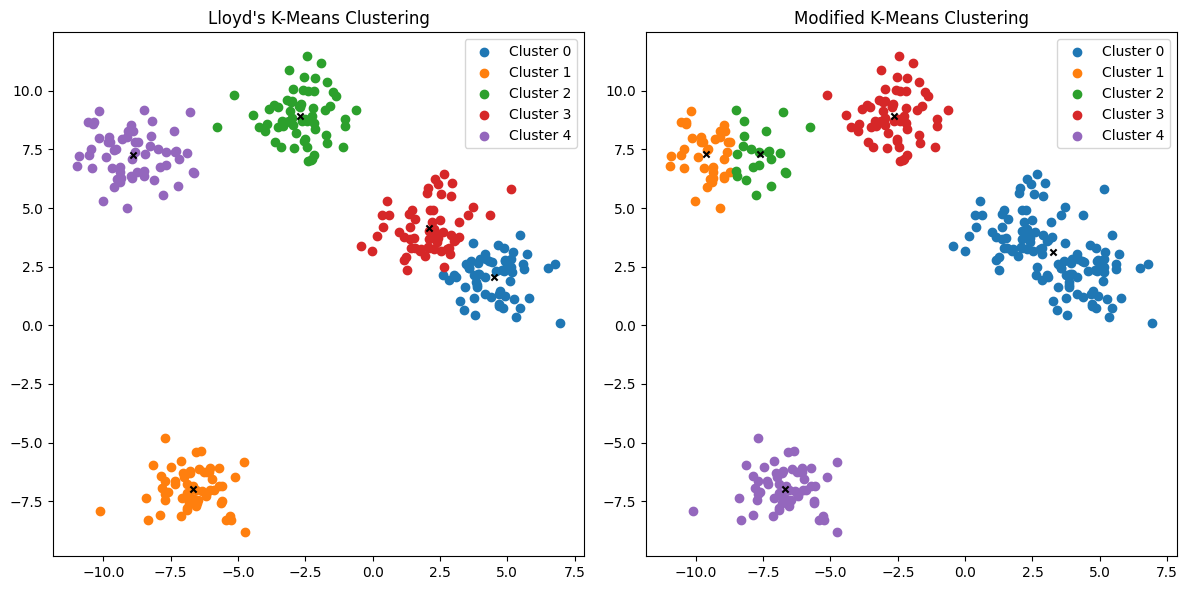

In [24]:
# Generate synthetic dataset
n_samples = 300
n_features = 2
n_clusters = 5

X, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=42)

# Apply Lloyd's K-Means Clustering
lloyd_kmeans = KMeansClustering(X, n_clusters)
lloyd_kmeans.fit()
lloyd_clusters = lloyd_kmeans.get_clusters()
lloyd_centroids = lloyd_kmeans.get_centroids()

# Apply Modified K-Means Clustering
modified_kmeans = ModifiedKMeansClustering(X, n_clusters)
modified_kmeans.fit()
modified_clusters = modified_kmeans.get_clusters()
modified_centroids = modified_kmeans.get_centroids()

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Lloyd's K-Means Clustering")
for i, cluster in enumerate(lloyd_clusters):
	plt.scatter(cluster.points[:, 0], cluster.points[:, 1], label=f'Cluster {i}')
	plt.scatter(cluster.mean[0], cluster.mean[1], s=20, marker='x', color='black')
plt.legend()

plt.subplot(122)
plt.title("Modified K-Means Clustering")
for i, cluster in enumerate(modified_clusters):
	plt.scatter(cluster.points[:, 0], cluster.points[:, 1], label=f'Cluster {i}')
	plt.scatter(cluster.mean[0], cluster.mean[1], s=20, marker='x', color='black')
plt.legend()

plt.tight_layout()
plt.show()